##  A simple convolutional neural net for MNIST classification with data augmentation and early stopping
A model contains: 
 - batch_norm
 - dropout
 - exponentialy decaying learning rate
 
In this notebook we will train and test CNN model on the augmented data.

In [1]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import sys

import blosc
import seaborn

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

sys.path.append("..")
sys.path.append("..\\..")

from my_batch import MnistBatch
from dataset import DatasetIndex, Dataset
from dataset import F, V, B
from my_batch import draw_stats, draw_digit
from mnist_model import MyMnistModel
from dataset.dataset.opensets import MNIST

## Load data

Let us load all data at once instead of doing this for every batch because it can all be loaded in memory.

## Create dataset:

In [3]:
mnistset = MNIST(batch_class=MnistBatch)

ExtractingExtractingExtractingExtracting    C:\Users\Dari\AppData\Local\Temp\t10k-labels-idx1-ubyte.gzC:\Users\Dari\AppData\Local\Temp\train-labels-idx1-ubyte.gzC:\Users\Dari\AppData\Local\Temp\train-images-idx3-ubyte.gzC:\Users\Dari\AppData\Local\Temp\t10k-images-idx3-ubyte.gz





## Train on the original data

In [4]:
SIZE = 28
BATCH_SIZE = 100
IMAGE_SIZE = 28

In [5]:
placeholders_config = {'images': {'shape': (IMAGE_SIZE, IMAGE_SIZE, 1),
                                 'name': 'reshaped_images'},
                       'labels': {'classes' : 10,
                                  'transform': 'ohe',
                                  'name': 'targets'}}

In [6]:
config = {'inputs': placeholders_config,
          'input_block/inputs': 'images',
          'body/keep_prob': 0.2,
          'output': dict(ops=['labels', 'accuracy'], data_format='channels_last')
         }

In [7]:
ppl = (mnistset.train.p
                     .init_variable('acc_history', init_on_each_run=list)
                     .init_model('static', MyMnistModel, 'MyMnistModel',
                      config=config)
                     .train_model('MyMnistModel', fetches='accuracy', feed_dict={'images': B('images'),
                                                                                 'labels': B('labels')},
                                  save_to=V('acc_history'), mode='a'))

kwargs  {'batch_norm': {'momentum': 0.1}, 'keep_prob': 0.2, 'is_training': <tf.Tensor 'MyMnistModel/globals/is_training:0' shape=<unknown> dtype=bool>}


In [8]:
ppl_test = (mnistset.test.p
                    .init_variable('test_acc_history', init_on_each_run=list)
                    .import_model('MyMnistModel', ppl)
                    .predict_model('MyMnistModel', fetches='accuracy', feed_dict={'images': B('images'),
                                                                                  'labels': B('labels')},
                                   save_to=V('test_acc_history'), mode='a'))

In [9]:
max_accuracy = 0.0
window = 50
sum_window = 0.0
stop_condition = 0.9

In [10]:
for i in tqdm(range(1000)):
    ppl.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
    ppl_test.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
    current_acc = ppl.get_variable('acc_history')[-1]

    if current_acc > max_accuracy:
        max_accuracy = current_acc
    if i % 50 == 0:
        cr = sum_window / window * max_accuracy 
        sum_window = sum(ppl.get_variable('acc_history')[i - window + 1: i])
        if cr > stop_condition: # do early stopping
            break

Widget Javascript not detected.  It may not be installed or enabled properly.


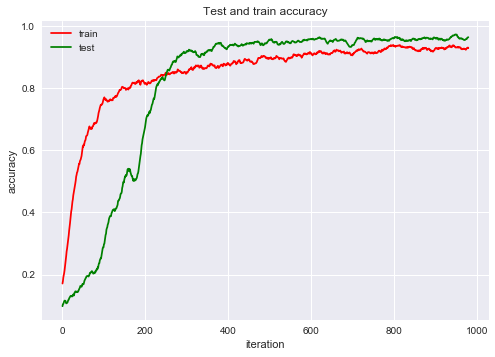

In [11]:
draw_stats([ppl.get_variable('acc_history'), ppl_test.get_variable('test_acc_history')], \
           ['train', 'test'], 'Test and train accuracy')

## Test on augmented data (shifted, rotated, scaled)

In [12]:
ppl_test_shift = (mnistset.test.p
                        .shift_flattened_pic()
                        .random_rotate(p=1, angle=(-10, 10), preserve_shape=True)
                        .random_scale(p=1, factor=(.8, 1.2))
                        .init_variable('augmented_acc_history', init_on_each_run=list)
                        .import_model('MyMnistModel', ppl)
                        .predict_model('MyMnistModel', fetches='accuracy', feed_dict={'images': B('images'),
                                                                                      'labels': B('labels')},
                                       save_to=V('augmented_acc_history'), mode='a'))

In [13]:
for i in tqdm(range(400)):
    ppl_test_shift.next_batch(100, n_epochs=None)

Widget Javascript not detected.  It may not be installed or enabled properly.


Predictably we see that our net badly predicts augmented data

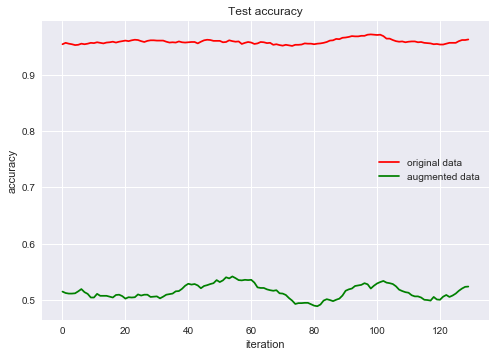

In [14]:
draw_stats([ppl_test.get_variable('test_acc_history')[-150:],
            ppl_test_shift.get_variable('augmented_acc_history')[-150:]],
            ['original data', 'augmented data'], 'Test accuracy')

Let's see some examples where the net makes mistakes:

In [15]:
ppl_results = (mnistset.test.pipeline() 
                            .shift_flattened_pic() 
                            .random_rotate(p=1, angle=(-60, 60), preserve_shape=True) 
                            .random_scale(p=1, factor=(.8, 1.2)) 
                            .init_variable('y_predict', init_on_each_run=list)
                            .init_variable('y_true', init_on_each_run=list)
                            .init_variable('probs', init_on_each_run=list)
                            .init_variable('pics', init_on_each_run=list)
                            .import_model('MyMnistModel', ppl)
                            .predict_model('MyMnistModel', fetches=[('predicted_labels'), ('labels'), 
                                                                    ('MyMnistModel/predicted_prob'), ('images')], 
                                           feed_dict={'images': B('images'),
                                                      'labels': B('labels')},
                                           save_to=[V('y_predict'), V('y_true'), V('probs'), V('pics')], mode='a'))

In [16]:
ppl_results.next_batch(100, n_epochs=None)

In [17]:
y_predict = ppl_results.get_variable('y_predict')
y_true = ppl_results.get_variable('y_true')
probs = ppl_results.get_variable('probs')
pics = ppl_results.get_variable('pics')

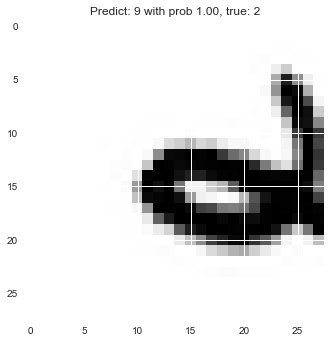

In [18]:
draw_digit(pics,y_predict, y_true, probs, answer=False)

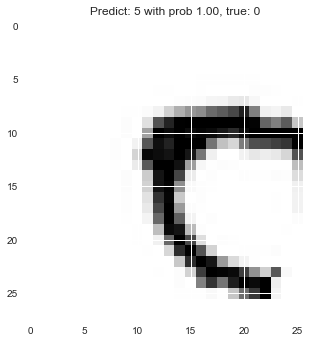

In [19]:
draw_digit(pics,y_predict, y_true, probs, answer=False)

## Let's train on augmented data

In [20]:
# pipeline for train
ppl_shift = (mnistset.train.pipeline()
                          .shift_flattened_pic()
                          .random_rotate(p=1, angle=(-10, 10), preserve_shape=True)
                          .random_scale(p=1, factor=(.8, 1.2))
                          .init_variable('acc_history', init_on_each_run=list)
                          .import_model('MyMnistModel', ppl)
                          .train_model('MyMnistModel', fetches='accuracy', feed_dict={'images': B('images'),
                                                                                      'labels': B('labels')},
                                       save_to=V('acc_history'), mode='a'))

In [21]:
# # pipeline for train
# ppl_test_shift = (mnistset.train.pipeline()
#                           .shift_flattened_pic()
#                           .random_rotate(p=1, angle=(-10, 10), preserve_shape=True)
#                           .random_scale(p=1, factor=(.8, 1.2))
#                           .init_variable('acc_history', init_on_each_run=list)
#                           .import_model('MyMnistModel', ppl)
#                           .train_model('MyMnistModel', fetches='accuracy', feed_dict={'images': B('images'),
#                                                                                       'labels': B('labels')},
#                                        save_to=V('acc_history'), mode='a'))

In [22]:
for i in tqdm(range(1000)):
    ppl_shift.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
    ppl_test_shift.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
    current_acc = ppl_shift.get_variable('acc_history')[-1]

    if current_acc > max_accuracy:
        max_accuracy = current_acc
    if i % 50 == 0:
        cr = sum_window / window * max_accuracy 
        sum_window = sum(ppl_shift.get_variable('acc_history')[i - window + 1: i])
        if cr > stop_condition: # do early stopping
            break

Widget Javascript not detected.  It may not be installed or enabled properly.


In [23]:
# for i in tqdm(range(1000)):
#     ppl_shift.next_batch(100, n_epochs=None)
#     ppl_test_shift.next_batch(100, n_epochs=None)

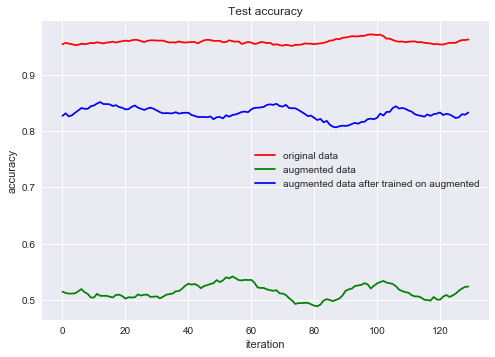

In [24]:
draw_stats([ppl_test.get_variable('test_acc_history')[-150:],  
            ppl_test_shift.get_variable('augmented_acc_history')[250:400],
            ppl_test_shift.get_variable('augmented_acc_history')[-150:]],
           ['original data', 'augmented data', 'augmented data after trained on augmented'],
           'Test accuracy')

In [25]:
ppl_results = (mnistset.test.pipeline() 
                            .shift_flattened_pic() 
                            .random_rotate(p=1, angle=(-10, 10), preserve_shape=True) 
                            .random_scale(p=1, factor=(.8, 1.2)) 
                            .init_variable('y_predict', init_on_each_run=list)
                            .init_variable('y_true', init_on_each_run=list)
                            .init_variable('probs', init_on_each_run=list)
                            .init_variable('pics', init_on_each_run=list)
                            .import_model('MyMnistModel', ppl)
                            .predict_model('MyMnistModel', fetches=[('predicted_labels'), ('labels'), 
                                                                    ('MyMnistModel/predicted_prob'), ('images')], 
                                                           feed_dict={'images': B('images'),
                                                                      'labels': B('labels')},
                                           save_to=[V('y_predict'), V('y_true'), V('probs'), V('pics')], mode='a'))

In [26]:
ppl_results.next_batch(100, n_epochs=None)

In [27]:
y_predict = ppl_results.get_variable('y_predict')
y_true = ppl_results.get_variable('y_true')
probs = ppl_results.get_variable('probs')
pics = ppl_results.get_variable('pics')

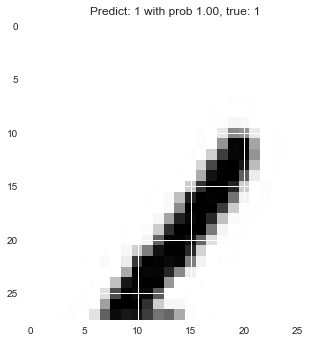

In [28]:
draw_digit(pics,y_predict, y_true, probs, answer=True)

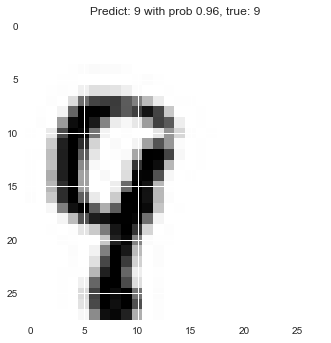

In [29]:
draw_digit(pics,y_predict, y_true, probs, answer=True)

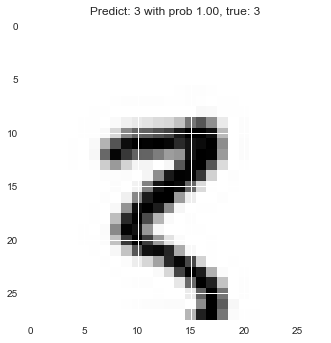

In [30]:
draw_digit(pics,y_predict, y_true, probs, answer=True)

But we still have a space for improvement:

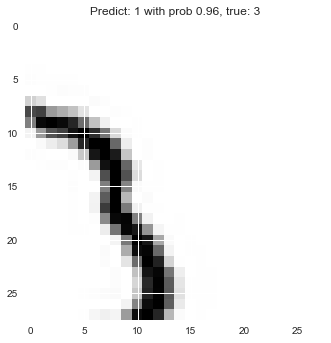

In [31]:
draw_digit(pics,y_predict, y_true, probs, answer=False)

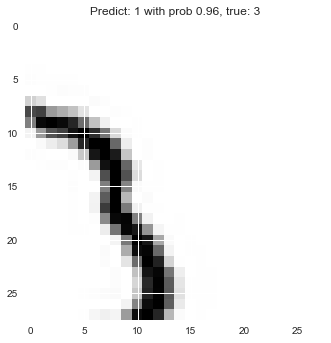

In [32]:
draw_digit(pics,y_predict, y_true, probs, answer=False)

In [33]:
print('Test accuracy on the original data: %.2f %%' % (100.0*np.mean(ppl_test.get_variable('test_acc_history')[-250:])))
print('Test accuracy on the augmented data: %.2f %%' % (100.0*np.mean(ppl_test_shift.get_variable('augmented_acc_history')[150:400])))
print('Test accuracy on the augmented data after trained on the augmented data: %.2f %%' %
      (100.0*np.mean(ppl_test_shift.get_variable('augmented_acc_history')[-250:])))

Test accuracy on the original data: 95.82 %
Test accuracy on the augmented data: 51.40 %
Test accuracy on the augmented data after trained on the augmented data: 83.07 %
